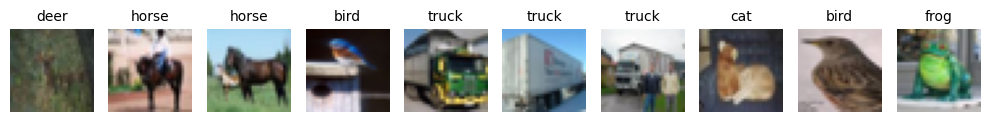

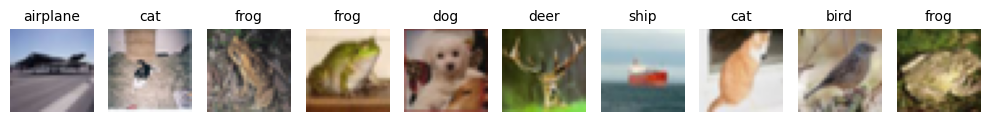

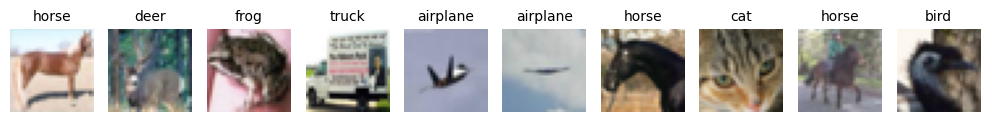

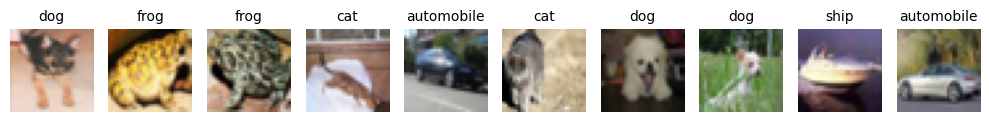

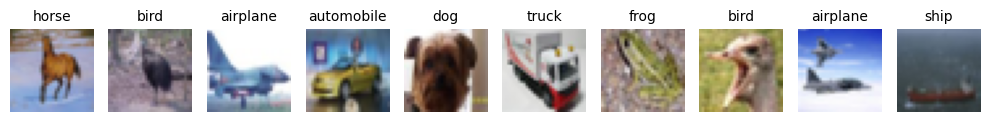

(50000, 32, 32, 3)
50000


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'


# Load the batch 
validation_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch')
# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']


def load_cifar10_batches(cifar10_dir, batch_ids):
    images = []
    labels = []
    
    for batch_id in batch_ids:
        batch_path = os.path.join(cifar10_dir, f'data_batch_{batch_id}')
        with open(batch_path, 'rb') as file:
            batch = pickle.load(file, encoding='bytes')
            img = batch[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
            lb = batch[b'labels']
            plt.figure(figsize=(10, 10))  # Adjusted figure size for better visibility
            for i in range(10):  # Loop through the first 100 images
                plt.subplot(1, 10, i + 1)  # Arrange plots in 10x10 grid
                plt.imshow(img[i+10])
                plt.title(label_names[lb[i+10]].decode('utf-8'), fontsize=10)  # Ensure title is small enough to fit
                plt.axis('off')
            plt.tight_layout()  # Adjust subplots to fit in the figure area
            plt.show()
            
            images.append(batch[b'data'])
            labels.append(batch[b'labels'])
    
    images = np.concatenate(images).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    #print(type(images))
    #print(images.shape)
    #images = images.astype('float32')
    labels = np.concatenate(labels)
    
    return images, labels



train_images, train_labels = load_cifar10_batches(cifar10_dir, range(1, 6))
validation_images = validation_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)#.astype('float32')
validation_labels = validation_batch[b'labels']
print(train_images.shape)
print(len(train_labels))
#print(validation_images[0])
#print(train_images[0])
import numpy as np

# Concatenate the training and validation images
train_images = np.concatenate((train_images, validation_images), axis=0)

# Concatenate the training and validation labels
train_labels = np.concatenate((train_labels, validation_labels), axis=0)

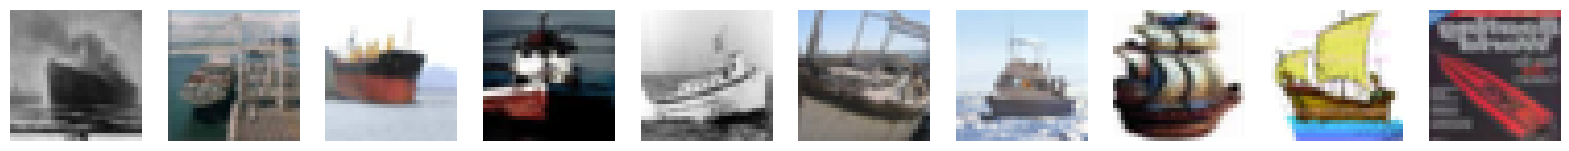

In [2]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

# Load the batch 
test_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')

# Extract images
images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 



plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [3]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images, labels = None, transform=None,test=False,gan = False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        self.test = test
        self.gan = gan
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx];

        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.gan:
            return image, 1
            
        if self.test:
            return image
        
        label = self.labels[idx]
        
        return image, label

In [4]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

transforms_train = albumentations.Compose(
    [

        albumentations.Resize(64, 64),
        albumentations.HorizontalFlip(p=0.5),
        #albumentations.VerticalFlip(p=0.5),
        albumentations.Rotate(limit=45, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=(-0.5, 0.5), p=0.5),
        albumentations.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=(-0.2,0.5), rotate_limit=0
        ),
        albumentations.Normalize(
            [0.4914, 0.4822, 0.4465],[0.247, 0.243, 0.261],
            max_pixel_value=255.0, always_apply=True
        ),
        ToTensorV2(p=1.0),
    ]
)

transforms_test = albumentations.Compose(
        [
            albumentations.Resize(64, 64),
            #albumentations.Resize(144, 144),
            albumentations.Normalize(
                [0.4914, 0.4822, 0.4465],[0.247, 0.243, 0.261],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0)
        ]
    )

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets 
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,ExponentialLR
# net = torchvision.models.resnet18()
# in_features = net.fc.in_features
# net.fc = nn.Linear(in_features, 10)

In [6]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torch.optim as optim

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 64, 4, stride=2, padding=1), # Assuming 3-channel images
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, 4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)
import torch
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, in_features):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, num_residual_blocks=2):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 16, 7),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Downsample
        self.downsample = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 96, 3, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        self.resblocks = nn.Sequential(
            *[ResBlock(96) for _ in range(num_residual_blocks)]
        )

        # Upsample
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(96, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(16, input_channels, 7),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample(x)
        x = self.resblocks(x)
        x = self.upsample(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 4, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(4, 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    # Initialize networks
G_A2B = Generator()
G_B2A = Generator()
D_A = Discriminator()
D_B = Discriminator()

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_A2B = G_A2B.to(device)
G_B2A = G_B2A.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

In [8]:
loader_A = ImageDataset(validation_images, train_labels,transform = transforms_test)

loader_B = ImageDataset(images, gan = True, transform = transforms_test )

loader_A = DataLoader(loader_A, batch_size=64, shuffle=True, drop_last=False)
loader_B = DataLoader(loader_B, batch_size=64, shuffle=True, drop_last=False)

In [9]:
import torch

# Assuming 'loader_A' and 'loader_B' are your DataLoader instances for domain A and B.
# Number of epochs
n_epochs = 40

# Lambda terms for cycle and identity loss
lambda_cycle = 5.0
lambda_identity = 1.0
from tqdm.auto import tqdm
for epoch in range(n_epochs):
    for batch_A, batch_B in tqdm(zip(loader_A, loader_B)):
        real_A = batch_A[0].to(device)
        real_B = batch_B[0].to(device)

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        same_B = G_A2B(real_B)
        loss_identity_B = criterion_cycle(same_B, real_B) * lambda_identity
        same_A = G_B2A(real_A)
        loss_identity_A = criterion_cycle(same_A, real_A) * lambda_identity

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_A = G_B2A(real_B)
        pred_fake = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recovered_A = G_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_cycle

        recovered_B = G_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_cycle

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = D_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = D_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = D_B(real_B)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = D_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch {epoch}/{n_epochs} finished")
    print(f"Loss G: {loss_G.item():.4f}, "
          f"Loss D_X: {loss_D_A.item():.4f}, Loss D_Y: {loss_D_B.item():.4f}")


0it [00:00, ?it/s]

Epoch 0/40 finished
Loss G: 4.3216, Loss D_X: 0.2493, Loss D_Y: 0.2489


0it [00:00, ?it/s]

Epoch 1/40 finished
Loss G: 4.3606, Loss D_X: 0.2481, Loss D_Y: 0.2466


0it [00:00, ?it/s]

Epoch 2/40 finished
Loss G: 4.3984, Loss D_X: 0.2487, Loss D_Y: 0.2272


0it [00:00, ?it/s]

Epoch 3/40 finished
Loss G: 3.7643, Loss D_X: 0.2512, Loss D_Y: 0.1956


0it [00:00, ?it/s]

Epoch 4/40 finished
Loss G: 4.3106, Loss D_X: 0.2427, Loss D_Y: 0.1817


0it [00:00, ?it/s]

Epoch 5/40 finished
Loss G: 4.5416, Loss D_X: 0.2308, Loss D_Y: 0.1734


0it [00:00, ?it/s]

Epoch 6/40 finished
Loss G: 5.9765, Loss D_X: 0.1671, Loss D_Y: 0.0976


0it [00:00, ?it/s]

Epoch 7/40 finished
Loss G: 4.7984, Loss D_X: 0.2008, Loss D_Y: 0.1313


0it [00:00, ?it/s]

Epoch 8/40 finished
Loss G: 4.5275, Loss D_X: 0.1420, Loss D_Y: 0.0826


0it [00:00, ?it/s]

Epoch 9/40 finished
Loss G: 4.4501, Loss D_X: 0.1403, Loss D_Y: 0.1144


0it [00:00, ?it/s]

Epoch 10/40 finished
Loss G: 4.2482, Loss D_X: 0.1126, Loss D_Y: 0.0830


0it [00:00, ?it/s]

Epoch 11/40 finished
Loss G: 4.5954, Loss D_X: 0.0726, Loss D_Y: 0.0843


0it [00:00, ?it/s]

Epoch 12/40 finished
Loss G: 4.7266, Loss D_X: 0.0588, Loss D_Y: 0.0504


0it [00:00, ?it/s]

Epoch 13/40 finished
Loss G: 5.1898, Loss D_X: 0.0858, Loss D_Y: 0.0143


0it [00:00, ?it/s]

Epoch 14/40 finished
Loss G: 5.2806, Loss D_X: 0.0421, Loss D_Y: 0.0145


0it [00:00, ?it/s]

Epoch 15/40 finished
Loss G: 5.1562, Loss D_X: 0.0252, Loss D_Y: 0.1452


0it [00:00, ?it/s]

Epoch 16/40 finished
Loss G: 5.9568, Loss D_X: 0.0091, Loss D_Y: 0.0055


0it [00:00, ?it/s]

Epoch 17/40 finished
Loss G: 4.5952, Loss D_X: 0.0071, Loss D_Y: 0.0089


0it [00:00, ?it/s]

Epoch 18/40 finished
Loss G: 4.8859, Loss D_X: 0.0099, Loss D_Y: 0.0091


0it [00:00, ?it/s]

Epoch 19/40 finished
Loss G: 4.8432, Loss D_X: 0.0058, Loss D_Y: 0.0076


0it [00:00, ?it/s]

Epoch 20/40 finished
Loss G: 4.9607, Loss D_X: 0.0041, Loss D_Y: 0.0062


0it [00:00, ?it/s]

Epoch 21/40 finished
Loss G: 5.4804, Loss D_X: 0.0044, Loss D_Y: 0.0021


0it [00:00, ?it/s]

Epoch 22/40 finished
Loss G: 4.4009, Loss D_X: 0.0046, Loss D_Y: 0.0058


0it [00:00, ?it/s]

Epoch 23/40 finished
Loss G: 4.8072, Loss D_X: 0.0019, Loss D_Y: 0.0011


0it [00:00, ?it/s]

Epoch 24/40 finished
Loss G: 5.4139, Loss D_X: 0.0081, Loss D_Y: 0.0022


0it [00:00, ?it/s]

Epoch 25/40 finished
Loss G: 5.8865, Loss D_X: 0.0010, Loss D_Y: 0.0005


0it [00:00, ?it/s]

Epoch 26/40 finished
Loss G: 4.9151, Loss D_X: 0.0035, Loss D_Y: 0.0004


0it [00:00, ?it/s]

Epoch 27/40 finished
Loss G: 6.1029, Loss D_X: 0.0007, Loss D_Y: 0.0004


0it [00:00, ?it/s]

Epoch 28/40 finished
Loss G: 5.9163, Loss D_X: 0.0004, Loss D_Y: 0.0006


0it [00:00, ?it/s]

Epoch 29/40 finished
Loss G: 4.5401, Loss D_X: 0.0005, Loss D_Y: 0.0021


0it [00:00, ?it/s]

Epoch 30/40 finished
Loss G: 5.4690, Loss D_X: 0.0003, Loss D_Y: 0.0004


0it [00:00, ?it/s]

Epoch 31/40 finished
Loss G: 5.2226, Loss D_X: 0.0007, Loss D_Y: 0.0004


0it [00:00, ?it/s]

Epoch 32/40 finished
Loss G: 4.9763, Loss D_X: 0.0004, Loss D_Y: 0.0004


0it [00:00, ?it/s]

Epoch 33/40 finished
Loss G: 4.6259, Loss D_X: 0.0030, Loss D_Y: 0.0003


0it [00:00, ?it/s]

Epoch 34/40 finished
Loss G: 4.8402, Loss D_X: 0.0003, Loss D_Y: 0.0006


0it [00:00, ?it/s]

Epoch 35/40 finished
Loss G: 5.2902, Loss D_X: 0.0004, Loss D_Y: 0.0003


0it [00:00, ?it/s]

Epoch 36/40 finished
Loss G: 5.0543, Loss D_X: 0.0002, Loss D_Y: 0.0003


0it [00:00, ?it/s]

Epoch 37/40 finished
Loss G: 5.4424, Loss D_X: 0.0002, Loss D_Y: 0.0003


0it [00:00, ?it/s]

Epoch 38/40 finished
Loss G: 4.5214, Loss D_X: 0.0004, Loss D_Y: 0.0003


0it [00:00, ?it/s]

Epoch 39/40 finished
Loss G: 4.9980, Loss D_X: 0.0002, Loss D_Y: 0.0002


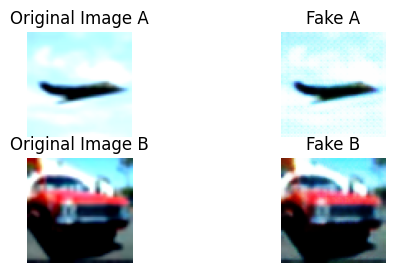

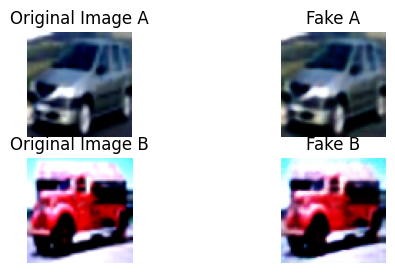

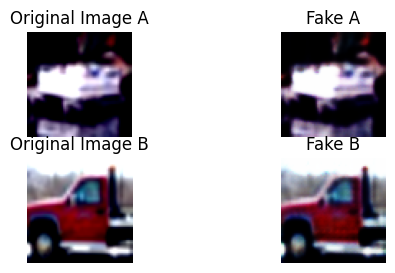

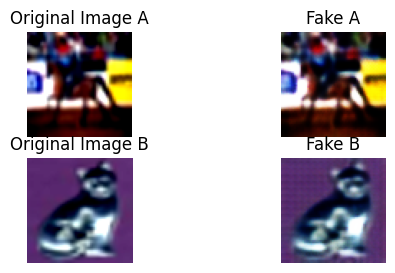

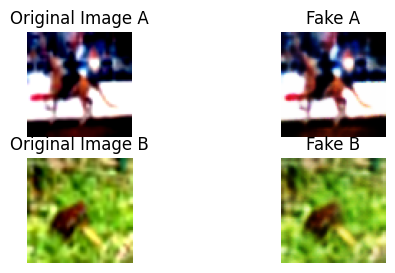

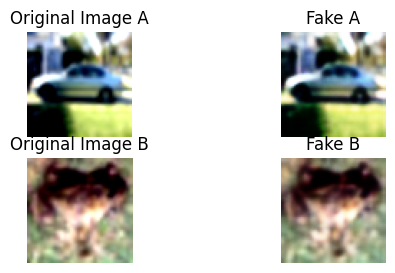

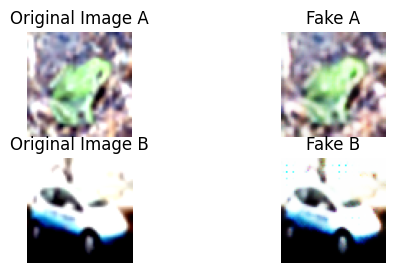

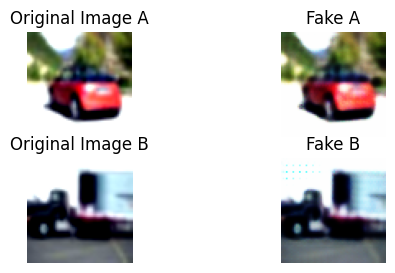

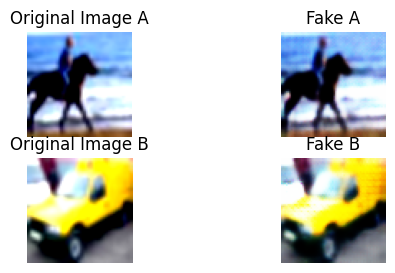

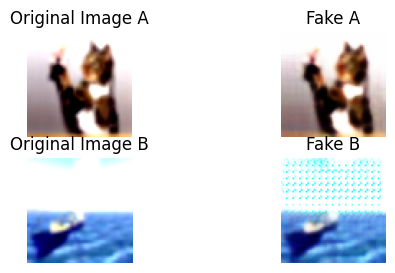

In [10]:
import matplotlib.pyplot as plt
import torch

def visualize_cycleGAN_results(model_G_A2B, model_G_B2A, test_loader_A, test_loader_B):
    # Switch models to evaluation mode
    model_G_A2B.eval()
    model_G_B2A.eval()
    count = 0
    with torch.no_grad(): # No need to track gradients
        for batchA,batchB in zip(test_loader_A,test_loader_B):
            real_A, _ = batchA
            real_B, _ = batchB
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            count+=1;
            
            # Generate images from domain A to B and back to A
            fake_A = model_G_A2B(real_A)
            fake_B = model_G_B2A(real_B)
            
            # Move images back to CPU for visualization
            real_A = real_A.cpu()
            real_B = real_B.cpu()
            fake_A = fake_A.cpu()
            fake_B = fake_B.cpu()

            # Plot the original, transformed, and reconstructed images
            plt.figure(figsize=(6, 3))
            
            # Display real image
            plt.subplot(2, 2, 1)
            plt.title("Original Image A")
            plt.imshow(real_A[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
             # Display real image
            plt.subplot(2, 2, 2)
            plt.title("Fake A")
            plt.imshow(fake_A[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
            # Display real image
            plt.subplot(2, 2, 3)
            plt.title("Original Image B")
            plt.imshow(real_B[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
             # Display real image
            plt.subplot(2, 2, 4)
            plt.title("Fake B")
            plt.imshow(fake_B[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')

            plt.show()
            if count == 10:
                break # Just show one set of images for example

# Assuming model_G_A2B, model_G_B2A, and test_loader_A are defined and loaded
visualize_cycleGAN_results(G_A2B, G_B2A, loader_A,loader_B)


In [11]:
G_A2B.eval()
G_B2A.eval()

Generator(
  (initial): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (downsample): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (resblocks): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad

In [12]:
'''DLA in PyTorch.

Reference:
    Deep Layer Aggregation. https://arxiv.org/abs/1707.06484
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        

        self.layer3 = Tree(block,  32,  64, level=1, stride=2)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=1, stride=2)
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=2, stride=2, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True)
#         )
        #self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        #out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# def test():
#     net = DLA()
#     print(net)
#     x = torch.randn(1, 3, 32, 32)
#     y = net(x)
#     print(y.size())


net = DLA()

In [13]:
import timm
parent = timm.create_model('dla102', pretrained=True,num_classes=10)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [14]:
# !pip install torch-summary

In [15]:
# from torchsummary import summary
# summary(model, (3, 64, 64))

In [16]:
# x = model(transforms_test(image=images[0])['image'].unsqueeze(0))
# print(x)

In [17]:
# !pip install torch-summary

In [18]:
# from torchsummary import summary
# summary(net, (3, 32, 32))

In [19]:
#!pip install torch-summary

In [20]:
# from torchsummary import summary
# summary(net, (3, 32, 32))

In [21]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(count_parameters(net))

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net  = net.to(device)
parent = parent.to(device)

In [23]:
from tqdm.auto import tqdm

def train_model(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0002,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        net.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.3:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            #print(y.shape)
            #print(y)
            y_hat = net(x)
            #print(y_hat.shape)
            #print(y_hat)
            #print(y_hat.argmax(dim=1).type(y.dtype))
            loss_temp = loss(y_hat, y)
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")



In [24]:
from tqdm.auto import tqdm

def train_parent(train_loader):
    losses = []
    optimizer = optim.Adam(parent.parameters(), lr=0.00007,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        parent.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.3:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            #print(y.shape)
            #print(y)
            y_hat = parent(x)
            #print(y_hat.shape)
            #print(y_hat)
            #print(y_hat.argmax(dim=1).type(y.dtype))
            loss_temp = loss(y_hat, y)
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")


In [25]:
# class DistillationLoss(nn.Module):
#     def __init__(self, temperature=1):
#         super(DistillationLoss, self).__init__()
#         self.temperature = temperature

#     def forward(self, outputs_student, outputs_teacher):
#         soft_targets = nn.functional.softmax(outputs_teacher / self.temperature, dim=1)
#         log_probs = nn.functional.log_softmax(outputs_student / self.temperature, dim=1)
#         return nn.KLDivLoss(reduction='batchmean')(log_probs, soft_targets)


import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temperature=1.0, alpha=0.5):
        """
        :param temperature: Temperature parameter to soften probability distributions.
        :param alpha: Weighting factor for the distillation loss vs. the standard loss.
        """
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, outputs_student, outputs_teacher, labels=None):
        """
        Compute the distillation loss between the student and teacher outputs.
        If labels are provided, also compute the standard loss and return a weighted sum.
        """
        soft_targets = F.softmax(outputs_teacher / self.temperature, dim=1)
        log_probs = F.log_softmax(outputs_student / self.temperature, dim=1)
        distillation_loss = self.kl_div(log_probs, soft_targets)
        
        if labels is not None:
            standard_loss = F.cross_entropy(outputs_student, labels)
            return self.alpha * standard_loss + (1 - self.alpha) * distillation_loss
        else:
            return distillation_loss


In [26]:
from tqdm.auto import tqdm

def train_model_with_teacher(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0006,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
    distillation_loss = DistillationLoss(temperature=3) 
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        net.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.3:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)  
            y_hat = net(x)
            
            outputs_teacher = parent(x)
            outputs_student = net(x)
            
            loss_temp = loss(outputs_student, y) + distillation_loss(outputs_student, outputs_teacher)
            
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")



In [27]:
from tqdm.auto import tqdm

def teach_student(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0003,weight_decay=1e-5)
    teacher_optimizer = optim.Adam(parent.parameters(), lr=0.00003,weight_decay=1e-5)
    student_optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
    distillation_loss = DistillationLoss(temperature=3) 
    scheduler = ExponentialLR(teacher_optimizer, gamma=0.99,verbose=True)
    scheduler = ExponentialLR(student_optimizer, gamma=0.98,verbose=True)
    for i in range(epoch):
        acc = 0
        acc_t = 0
        loss_sum = 0
        net.train()
        parent.train()
        for x, y in tqdm(train_loader):
            teacher_optimizer.zero_grad()
            student_optimizer.zero_grad()
            x = x.to(device)
            #print(x.shape)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            
            outputs_teacher = parent(x)
            outputs_student = net(x)
            
            loss_teacher = loss(outputs_teacher, y)
            loss_student = loss(outputs_student, y) + distillation_loss(outputs_student, outputs_teacher)
#             print("loss")
#             print(loss(outputs_student, y))
#             print(distillation_loss(outputs_student, outputs_teacher))
#             print(outputs_teacher)
#             print(outputs_student)
            
            loss_sum += loss_teacher

            loss_teacher.backward(retain_graph=True)
#             loss_teacher.backward()
            loss_student.backward()
            teacher_optimizer.step()
            student_optimizer.step()
            
            acc += torch.sum(outputs_student.argmax(dim=1).type(y.dtype) == y)
            acc_t += torch.sum(outputs_teacher.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")
        print( "epoch: ", i, "loss=", loss_sum.item(), "teacher准确度=",(acc_t/(len(train_loader)*train_loader.batch_size)).item(),end="")


In [28]:
#from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,ExponentialLR

print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
validation_labels = np.array(validation_labels)
print(validation_labels.shape)

#train_dataset = ImageDataset(train_images, train_labels, transform=transforms_train)
train_dataset = ImageDataset(train_images, train_labels, transform=transforms_train)
validation_dataset = ImageDataset(validation_images, validation_labels, transform=transforms_test)
#submit_ds = ImageDataset(csv_file='/kaggle/input/classify-leaves/test.csv', root_dir='../input/classify-leaves', transform=transforms_test, label_return=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, drop_last=False)
#submit_loader = DataLoader(submit_ds, batch_size=32, shuffle=False, drop_last=False)

(60000, 32, 32, 3)
(60000,)
(10000, 32, 32, 3)
(10000,)


In [29]:
epoch = 40
train_parent(train_loader)

Adjusting learning rate of group 0 to 7.0000e-05.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8250e-05.
epoch:  0 loss= 2264.42236328125 训练集准确度= 0.6133562326431274

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6544e-05.
epoch:  1 loss= 742.915283203125 训练集准确度= 0.734158456325531

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4880e-05.
epoch:  2 loss= 636.9371337890625 训练集准确度= 0.7719383239746094

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3258e-05.
epoch:  3 loss= 609.2156372070312 训练集准确度= 0.78476482629776

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1677e-05.
epoch:  4 loss= 505.4071044921875 训练集准确度= 0.813532829284668

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0135e-05.
epoch:  5 loss= 485.269775390625 训练集准确度= 0.8239105939865112

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8631e-05.
epoch:  6 loss= 507.2115173339844 训练集准确度= 0.8178138732910156

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7166e-05.
epoch:  7 loss= 433.50091552734375 训练集准确度= 0.8418010473251343

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5736e-05.
epoch:  8 loss= 407.50555419921875 训练集准确度= 0.8515791893005371

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4343e-05.
epoch:  9 loss= 442.18402099609375 训练集准确度= 0.8398520946502686

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2984e-05.
epoch:  10 loss= 381.98663330078125 训练集准确度= 0.8578924536705017

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1660e-05.
epoch:  11 loss= 350.49957275390625 训练集准确度= 0.8692030906677246

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0368e-05.
epoch:  12 loss= 345.2648010253906 训练集准确度= 0.8729011416435242

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9109e-05.
epoch:  13 loss= 330.3990783691406 训练集准确度= 0.8768490552902222

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7881e-05.
epoch:  14 loss= 314.2279968261719 训练集准确度= 0.883328914642334

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6684e-05.
epoch:  15 loss= 308.90679931640625 训练集准确度= 0.8863939642906189

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5517e-05.
epoch:  16 loss= 291.9163818359375 训练集准确度= 0.8912080526351929

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4379e-05.
epoch:  17 loss= 313.73529052734375 训练集准确度= 0.8854944109916687

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3270e-05.
epoch:  18 loss= 304.8169250488281 训练集准确度= 0.887493371963501

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2188e-05.
epoch:  19 loss= 268.1477966308594 训练集准确度= 0.9014025926589966

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1133e-05.
epoch:  20 loss= 264.21197509765625 训练集准确度= 0.9017857313156128

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0105e-05.
epoch:  21 loss= 275.13543701171875 训练集准确度= 0.8968050479888916

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9102e-05.
epoch:  22 loss= 251.4686279296875 训练集准确度= 0.9060168266296387

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8125e-05.
epoch:  23 loss= 239.89669799804688 训练集准确度= 0.9110141396522522

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7172e-05.
epoch:  24 loss= 240.3560333251953 训练集准确度= 0.9108808636665344

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6242e-05.
epoch:  25 loss= 236.02447509765625 训练集准确度= 0.9115638732910156

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5336e-05.
epoch:  26 loss= 227.4856719970703 训练集准确度= 0.9146122336387634

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4453e-05.
epoch:  27 loss= 231.17568969726562 训练集准确度= 0.9138626456260681

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3592e-05.
epoch:  28 loss= 231.66287231445312 训练集准确度= 0.9138626456260681

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2752e-05.
epoch:  29 loss= 214.91989135742188 训练集准确度= 0.9202425479888916

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1933e-05.
epoch:  30 loss= 208.05502319335938 训练集准确度= 0.9226246476173401

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1135e-05.
epoch:  31 loss= 203.6772918701172 训练集准确度= 0.9249400496482849

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0356e-05.
epoch:  32 loss= 195.46224975585938 训练集准确度= 0.9257229566574097

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9597e-05.
epoch:  33 loss= 199.33673095703125 训练集准确度= 0.9258728623390198

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8858e-05.
epoch:  34 loss= 195.72972106933594 训练集准确度= 0.927422046661377

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8136e-05.
epoch:  35 loss= 193.2937774658203 训练集准确度= 0.9278884530067444

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7433e-05.
epoch:  36 loss= 184.23513793945312 训练集准确度= 0.9313366413116455

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6747e-05.
epoch:  37 loss= 177.70309448242188 训练集准确度= 0.9333855509757996

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6078e-05.
epoch:  38 loss= 182.4841766357422 训练集准确度= 0.9313865900039673

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5426e-05.
epoch:  39 loss= 178.5238800048828 训练集准确度= 0.9339019656181335

In [30]:
epoch = 80
teach_student(train_loader)
#net = parent
#train_model(train_loader,validation_loader)

Adjusting learning rate of group 0 to 3.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8000e-04.
epoch:  0 loss= 249.09730529785156 训练集准确度= 0.37483343482017517epoch:  0 loss= 249.09730529785156 teacher准确度= 0.9485607743263245

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6040e-04.
epoch:  1 loss= 206.95925903320312 训练集准确度= 0.5491238236427307epoch:  1 loss= 206.95925903320312 teacher准确度= 0.9529750943183899

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4119e-04.
epoch:  2 loss= 187.41390991210938 训练集准确度= 0.6300972700119019epoch:  2 loss= 187.41390991210938 teacher准确度= 0.9528751373291016

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2237e-04.
epoch:  3 loss= 172.1206512451172 训练集准确度= 0.6794876456260681epoch:  3 loss= 172.1206512451172 teacher准确度= 0.9553738236427307

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0392e-04.
epoch:  4 loss= 166.19210815429688 训练集准确度= 0.7098214626312256epoch:  4 loss= 166.19210815429688 teacher准确度= 0.9543410539627075

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8584e-04.
epoch:  5 loss= 159.17686462402344 训练集准确度= 0.7365738153457642epoch:  5 loss= 159.17686462402344 teacher准确度= 0.9553571939468384

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6813e-04.
epoch:  6 loss= 154.4481201171875 训练集准确度= 0.7553471922874451epoch:  6 loss= 154.4481201171875 teacher准确度= 0.9553071856498718

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5076e-04.
epoch:  7 loss= 149.2387237548828 训练集准确度= 0.7705723643302917epoch:  7 loss= 149.2387237548828 teacher准确度= 0.9563899636268616

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3375e-04.
epoch:  8 loss= 143.73033142089844 训练集准确度= 0.7846481800079346epoch:  8 loss= 143.73033142089844 teacher准确度= 0.957072913646698

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1707e-04.
epoch:  9 loss= 140.1307830810547 训练集准确度= 0.7972748279571533epoch:  9 loss= 140.1307830810547 teacher准确度= 0.9581390023231506

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0073e-04.
epoch:  10 loss= 137.6705780029297 训练集准确度= 0.8076192736625671epoch:  10 loss= 137.6705780029297 teacher准确度= 0.958755373954773

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8472e-04.
epoch:  11 loss= 134.1208953857422 训练集准确度= 0.8165478706359863epoch:  11 loss= 134.1208953857422 teacher准确度= 0.9591884613037109

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6902e-04.
epoch:  12 loss= 128.7797088623047 训练集准确度= 0.8231610059738159epoch:  12 loss= 128.7797088623047 teacher准确度= 0.960504412651062

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5364e-04.
epoch:  13 loss= 130.16006469726562 训练集准确度= 0.8303071856498718epoch:  13 loss= 130.16006469726562 teacher准确度= 0.9595715999603271

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3857e-04.
epoch:  14 loss= 123.33647155761719 训练集准确度= 0.8381030559539795epoch:  14 loss= 123.33647155761719 teacher准确度= 0.9613872766494751

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2380e-04.
epoch:  15 loss= 122.74162292480469 训练集准确度= 0.8430836796760559epoch:  15 loss= 122.74162292480469 teacher准确度= 0.9609708189964294

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0932e-04.
epoch:  16 loss= 120.27346801757812 训练集准确度= 0.8512126803398132epoch:  16 loss= 120.27346801757812 teacher准确度= 0.9622535109519958

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9514e-04.
epoch:  17 loss= 117.25843048095703 训练集准确度= 0.8547441363334656epoch:  17 loss= 117.25843048095703 teacher准确度= 0.9629031419754028

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8123e-04.
epoch:  18 loss= 117.82687377929688 训练集准确度= 0.8575426936149597epoch:  18 loss= 117.82687377929688 teacher准确度= 0.9622868299484253

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6761e-04.
epoch:  19 loss= 116.12994384765625 训练集准确度= 0.8622734546661377epoch:  19 loss= 116.12994384765625 teacher准确度= 0.9624367356300354

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5426e-04.
epoch:  20 loss= 117.19461059570312 训练集准确度= 0.8661381006240845epoch:  20 loss= 117.19461059570312 teacher准确度= 0.9615205526351929

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4117e-04.
epoch:  21 loss= 111.3825912475586 训练集准确度= 0.867703914642334epoch:  21 loss= 111.3825912475586 teacher准确度= 0.9640358686447144

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2835e-04.
epoch:  22 loss= 111.5411605834961 训练集准确度= 0.873184323310852epoch:  22 loss= 111.5411605834961 teacher准确度= 0.9638026356697083

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1578e-04.
epoch:  23 loss= 109.11528015136719 训练集准确度= 0.8767490983009338epoch:  23 loss= 109.11528015136719 teacher准确度= 0.9645022749900818

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0346e-04.
epoch:  24 loss= 108.42896270751953 训练集准确度= 0.8811967372894287epoch:  24 loss= 108.42896270751953 teacher准确度= 0.9644689559936523

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9140e-04.
epoch:  25 loss= 106.8382797241211 训练集准确度= 0.8820295929908752epoch:  25 loss= 106.8382797241211 teacher准确度= 0.9642190933227539

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7957e-04.
epoch:  26 loss= 104.41141510009766 训练集准确度= 0.8879098296165466epoch:  26 loss= 104.41141510009766 teacher准确度= 0.9659015536308289

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6798e-04.
epoch:  27 loss= 102.84999084472656 训练集准确度= 0.8894256353378296epoch:  27 loss= 102.84999084472656 teacher准确度= 0.9660348296165466

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5662e-04.
epoch:  28 loss= 99.42005920410156 训练集准确度= 0.8919576406478882epoch:  28 loss= 99.42005920410156 teacher准确度= 0.9680171012878418

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4548e-04.
epoch:  29 loss= 99.5064468383789 训练集准确度= 0.8927239179611206epoch:  29 loss= 99.5064468383789 teacher准确度= 0.9659681916236877

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3457e-04.
epoch:  30 loss= 101.14979553222656 训练集准确度= 0.8967217803001404epoch:  30 loss= 101.14979553222656 teacher准确度= 0.966484546661377

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2388e-04.
epoch:  31 loss= 99.43798065185547 训练集准确度= 0.8974547386169434epoch:  31 loss= 99.43798065185547 teacher准确度= 0.967234194278717

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1341e-04.
epoch:  32 loss= 102.94662475585938 训练集准确度= 0.8986374139785767epoch:  32 loss= 102.94662475585938 teacher准确度= 0.9657349586486816

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0314e-04.
epoch:  33 loss= 95.45692443847656 训练集准确度= 0.9021355509757996epoch:  33 loss= 95.45692443847656 teacher准确度= 0.9682169556617737

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9307e-04.
epoch:  34 loss= 94.08171081542969 训练集准确度= 0.90333491563797epoch:  34 loss= 94.08171081542969 teacher准确度= 0.968316912651062

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8321e-04.
epoch:  35 loss= 92.6155014038086 训练集准确度= 0.9049007296562195epoch:  35 loss= 92.6155014038086 teacher准确度= 0.969049870967865

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7355e-04.
epoch:  36 loss= 93.39933776855469 训练集准确度= 0.9070495963096619epoch:  36 loss= 93.39933776855469 teacher准确度= 0.9687166810035706

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6408e-04.
epoch:  37 loss= 94.50935363769531 训练集准确度= 0.9088985919952393epoch:  37 loss= 94.50935363769531 teacher准确度= 0.9676839113235474

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5480e-04.
epoch:  38 loss= 91.97734069824219 训练集准确度= 0.9133795499801636epoch:  38 loss= 91.97734069824219 teacher准确度= 0.9683002829551697

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4570e-04.
epoch:  39 loss= 92.82594299316406 训练集准确度= 0.9116804599761963epoch:  39 loss= 92.82594299316406 teacher准确度= 0.9681169986724854

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3679e-04.
epoch:  40 loss= 89.38358306884766 训练集准确度= 0.9144123196601868epoch:  40 loss= 89.38358306884766 teacher准确度= 0.9690998196601868

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2805e-04.
epoch:  41 loss= 91.21485137939453 训练集准确度= 0.9147455096244812epoch:  41 loss= 91.21485137939453 teacher准确度= 0.9691997766494751

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1949e-04.
epoch:  42 loss= 91.38465118408203 训练集准确度= 0.9170109629631042epoch:  42 loss= 91.38465118408203 teacher准确度= 0.9685001373291016

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1110e-04.
epoch:  43 loss= 86.5301742553711 训练集准确度= 0.9192264080047607epoch:  43 loss= 86.5301742553711 teacher准确度= 0.9702991843223572

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0288e-04.
epoch:  44 loss= 86.6626968383789 训练集准确度= 0.9202092289924622epoch:  44 loss= 86.6626968383789 teacher准确度= 0.9703158736228943

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9482e-04.
epoch:  45 loss= 87.92174530029297 训练集准确度= 0.9213253259658813epoch:  45 loss= 87.92174530029297 teacher准确度= 0.9692330956459045

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8692e-04.
epoch:  46 loss= 85.5378189086914 训练集准确度= 0.9231743216514587epoch:  46 loss= 85.5378189086914 teacher准确度= 0.9706823229789734

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7919e-04.
epoch:  47 loss= 85.37570190429688 训练集准确度= 0.9224580526351929epoch:  47 loss= 85.37570190429688 teacher准确度= 0.9702492356300354

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7160e-04.
epoch:  48 loss= 85.33135986328125 训练集准确度= 0.9246402382850647epoch:  48 loss= 85.33135986328125 teacher准确度= 0.9704158306121826

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6417e-04.
epoch:  49 loss= 83.07707977294922 训练集准确度= 0.9260561466217041epoch:  49 loss= 83.07707977294922 teacher准确度= 0.9714152812957764

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5689e-04.
epoch:  50 loss= 83.95885467529297 训练集准确度= 0.9275886416435242epoch:  50 loss= 83.95885467529297 teacher准确度= 0.9711487293243408

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4975e-04.
epoch:  51 loss= 84.4869155883789 训练集准确度= 0.9295876026153564epoch:  51 loss= 84.4869155883789 teacher准确度= 0.9705157279968262

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4275e-04.
epoch:  52 loss= 79.39358520507812 训练集准确度= 0.9314199090003967epoch:  52 loss= 79.39358520507812 teacher准确度= 0.9721315503120422

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3590e-04.
epoch:  53 loss= 81.453125 训练集准确度= 0.930720329284668epoch:  53 loss= 81.453125 teacher准确度= 0.9712320566177368

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2918e-04.
epoch:  54 loss= 82.3946533203125 训练集准确度= 0.929904043674469epoch:  54 loss= 82.3946533203125 teacher准确度= 0.9711487293243408

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2260e-04.
epoch:  55 loss= 83.58326721191406 训练集准确度= 0.9305370450019836epoch:  55 loss= 83.58326721191406 teacher准确度= 0.9710820913314819

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1614e-04.
epoch:  56 loss= 78.32422637939453 训练集准确度= 0.9334688186645508epoch:  56 loss= 78.32422637939453 teacher准确度= 0.9730477333068848

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0982e-04.
epoch:  57 loss= 79.42124938964844 训练集准确度= 0.9342184662818909epoch:  57 loss= 79.42124938964844 teacher准确度= 0.9714819192886353

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0363e-04.
epoch:  58 loss= 81.2293472290039 训练集准确度= 0.936200737953186epoch:  58 loss= 81.2293472290039 teacher准确度= 0.9716151356697083

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9755e-04.
epoch:  59 loss= 80.86682891845703 训练集准确度= 0.9358842372894287epoch:  59 loss= 80.86682891845703 teacher准确度= 0.9719150066375732

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9160e-04.
epoch:  60 loss= 76.58694458007812 训练集准确度= 0.9373167753219604epoch:  60 loss= 76.58694458007812 teacher准确度= 0.9735807776451111

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8577e-04.
epoch:  61 loss= 78.347412109375 训练集准确度= 0.9391325116157532epoch:  61 loss= 78.347412109375 teacher准确度= 0.9720649123191833

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8005e-04.
epoch:  62 loss= 78.19261932373047 训练集准确度= 0.9376332759857178epoch:  62 loss= 78.19261932373047 teacher准确度= 0.9727811813354492

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7445e-04.
epoch:  63 loss= 80.7117919921875 训练集准确度= 0.9375333189964294epoch:  63 loss= 80.7117919921875 teacher准确度= 0.9716484546661377

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6896e-04.
epoch:  64 loss= 76.81209564208984 训练集准确度= 0.9408149123191833epoch:  64 loss= 76.81209564208984 teacher准确度= 0.973131000995636

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6359e-04.
epoch:  65 loss= 76.88277435302734 训练集准确度= 0.9402485489845276epoch:  65 loss= 76.88277435302734 teacher准确度= 0.9730643630027771

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5831e-04.
epoch:  66 loss= 76.3427963256836 训练集准确度= 0.9403151869773865epoch:  66 loss= 76.3427963256836 teacher准确度= 0.9727978706359863

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5315e-04.
epoch:  67 loss= 76.99482727050781 训练集准确度= 0.9417977333068848epoch:  67 loss= 76.99482727050781 teacher准确度= 0.9728145003318787

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4808e-04.
epoch:  68 loss= 77.06208801269531 训练集准确度= 0.94239741563797epoch:  68 loss= 77.06208801269531 teacher准确度= 0.9723314642906189

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4312e-04.
epoch:  69 loss= 73.98126220703125 训练集准确度= 0.9430304169654846epoch:  69 loss= 73.98126220703125 teacher准确度= 0.9734475016593933

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3826e-04.
epoch:  70 loss= 76.84258270263672 训练集准确度= 0.9441298246383667epoch:  70 loss= 76.84258270263672 teacher准确度= 0.9724314212799072

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3349e-04.
epoch:  71 loss= 74.55072784423828 训练集准确度= 0.9452958703041077epoch:  71 loss= 74.55072784423828 teacher准确度= 0.9736807346343994

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2883e-04.
epoch:  72 loss= 76.21166229248047 训练集准确度= 0.9449793696403503epoch:  72 loss= 76.21166229248047 teacher准确度= 0.9722814559936523

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2425e-04.
epoch:  73 loss= 73.52906799316406 训练集准确度= 0.9453625082969666epoch:  73 loss= 73.52906799316406 teacher准确度= 0.9739972352981567

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1976e-04.
epoch:  74 loss= 70.84605407714844 训练集准确度= 0.9463120102882385epoch:  74 loss= 70.84605407714844 teacher准确度= 0.974163830280304

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1537e-04.
epoch:  75 loss= 72.18402862548828 训练集准确度= 0.9460954666137695epoch:  75 loss= 72.18402862548828 teacher准确度= 0.9743636846542358

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1106e-04.
epoch:  76 loss= 70.10803985595703 训练集准确度= 0.9486940503120422epoch:  76 loss= 70.10803985595703 teacher准确度= 0.97517991065979

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0684e-04.
epoch:  77 loss= 75.62366485595703 训练集准确度= 0.946045458316803epoch:  77 loss= 75.62366485595703 teacher准确度= 0.9736140966415405

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0270e-04.
epoch:  78 loss= 70.58480834960938 训练集准确度= 0.9487940073013306epoch:  78 loss= 70.58480834960938 teacher准确度= 0.9745802283287048

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9865e-04.
epoch:  79 loss= 71.76301574707031 训练集准确度= 0.9486441016197205epoch:  79 loss= 71.76301574707031 teacher准确度= 0.9738972783088684

In [31]:
epoch = 70
train_model_with_teacher(train_loader)

Adjusting learning rate of group 0 to 6.0000e-04.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8500e-04.
epoch:  0 loss= 382.65618896484375 训练集准确度= 0.8921408653259277

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7037e-04.
epoch:  1 loss= 389.55767822265625 训练集准确度= 0.8912746906280518

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5612e-04.
epoch:  2 loss= 379.08099365234375 训练集准确度= 0.8923574090003967

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4221e-04.
epoch:  3 loss= 364.5769348144531 训练集准确度= 0.8972215056419373

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2866e-04.
epoch:  4 loss= 370.3555908203125 训练集准确度= 0.8953391909599304

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1544e-04.
epoch:  5 loss= 364.665771484375 训练集准确度= 0.8977545499801636

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0255e-04.
epoch:  6 loss= 353.4223327636719 训练集准确度= 0.9006363749504089

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8999e-04.
epoch:  7 loss= 363.0230407714844 训练集准确度= 0.897354781627655

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7774e-04.
epoch:  8 loss= 351.3410949707031 训练集准确度= 0.8995369076728821

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6580e-04.
epoch:  9 loss= 342.8775939941406 训练集准确度= 0.902901828289032

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5415e-04.
epoch:  10 loss= 337.1794738769531 训练集准确度= 0.9051339626312256

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4280e-04.
epoch:  11 loss= 331.7909851074219 训练集准确度= 0.907499372959137

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3173e-04.
epoch:  12 loss= 336.57977294921875 训练集准确度= 0.9043510556221008

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2094e-04.
epoch:  13 loss= 328.8534851074219 训练集准确度= 0.9072495102882385

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1041e-04.
epoch:  14 loss= 313.5801696777344 训练集准确度= 0.9109141826629639

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0015e-04.
epoch:  15 loss= 321.1087646484375 训练集准确度= 0.9091984629631042

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9015e-04.
epoch:  16 loss= 312.48907470703125 训练集准确度= 0.9120969176292419

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8039e-04.
epoch:  17 loss= 308.8843688964844 训练集准确度= 0.9145122766494751

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7088e-04.
epoch:  18 loss= 310.0936584472656 训练集准确度= 0.9123467803001404

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6161e-04.
epoch:  19 loss= 304.9616394042969 训练集准确度= 0.9151952266693115

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5257e-04.
epoch:  20 loss= 299.4492492675781 训练集准确度= 0.9167110919952393

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4376e-04.
epoch:  21 loss= 287.3761901855469 训练集准确度= 0.9194096922874451

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3516e-04.
epoch:  22 loss= 289.81695556640625 训练集准确度= 0.9190431833267212

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2678e-04.
epoch:  23 loss= 298.3050537109375 训练集准确度= 0.9166444540023804

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1862e-04.
epoch:  24 loss= 284.9314880371094 训练集准确度= 0.9208422303199768

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1065e-04.
epoch:  25 loss= 287.70318603515625 训练集准确度= 0.919393002986908

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0288e-04.
epoch:  26 loss= 286.59942626953125 训练集准确度= 0.918310284614563

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9531e-04.
epoch:  27 loss= 273.9979248046875 训练集准确度= 0.9234741926193237

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8793e-04.
epoch:  28 loss= 268.12908935546875 训练集准确度= 0.9259061813354492

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8073e-04.
epoch:  29 loss= 275.2505798339844 训练集准确度= 0.9235407710075378

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7371e-04.
epoch:  30 loss= 267.4576416015625 训练集准确度= 0.9254231452941895

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6687e-04.
epoch:  31 loss= 263.4644470214844 训练集准确度= 0.9274054169654846

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6020e-04.
epoch:  32 loss= 268.0267028808594 训练集准确度= 0.9254064559936523

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5369e-04.
epoch:  33 loss= 253.17567443847656 训练集准确度= 0.9306203722953796

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4735e-04.
epoch:  34 loss= 252.8346710205078 训练集准确度= 0.930203914642334

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4117e-04.
epoch:  35 loss= 257.4747314453125 训练集准确度= 0.9290212392807007

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3514e-04.
epoch:  36 loss= 249.94384765625 训练集准确度= 0.9317530989646912

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2926e-04.
epoch:  37 loss= 253.83599853515625 训练集准确度= 0.9296708703041077

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2353e-04.
epoch:  38 loss= 244.53475952148438 训练集准确度= 0.9335188269615173

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1794e-04.
epoch:  39 loss= 244.13230895996094 训练集准确度= 0.9331523180007935

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1249e-04.
epoch:  40 loss= 248.78509521484375 训练集准确度= 0.9323861002922058

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0718e-04.
epoch:  41 loss= 238.55857849121094 训练集准确度= 0.9350680112838745

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0200e-04.
epoch:  42 loss= 241.39376831054688 训练集准确度= 0.9335521459579468

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9695e-04.
epoch:  43 loss= 236.0593719482422 训练集准确度= 0.9362340569496155

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9203e-04.
epoch:  44 loss= 241.8147735595703 训练集准确度= 0.9341018199920654

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8722e-04.
epoch:  45 loss= 228.9014892578125 训练集准确度= 0.9390325546264648

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8254e-04.
epoch:  46 loss= 232.2613067626953 训练集准确度= 0.9382163286209106

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7798e-04.
epoch:  47 loss= 238.33523559570312 训练集准确度= 0.935234546661377

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7353e-04.
epoch:  48 loss= 223.6918182373047 训练集准确度= 0.9405317306518555

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6919e-04.
epoch:  49 loss= 228.43502807617188 训练集准确度= 0.9379997849464417

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6496e-04.
epoch:  50 loss= 225.1805419921875 训练集准确度= 0.9403818249702454

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6084e-04.
epoch:  51 loss= 222.29335021972656 训练集准确度= 0.9405650496482849

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5682e-04.
epoch:  52 loss= 230.26336669921875 训练集准确度= 0.9373001456260681

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5290e-04.
epoch:  53 loss= 222.58828735351562 训练集准确度= 0.9403651356697083

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4908e-04.
epoch:  54 loss= 224.36058044433594 训练集准确度= 0.9399154186248779

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4535e-04.
epoch:  55 loss= 215.87754821777344 训练集准确度= 0.9429637789726257

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4171e-04.
epoch:  56 loss= 223.20068359375 训练集准确度= 0.9398987293243408

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3817e-04.
epoch:  57 loss= 220.36167907714844 训练集准确度= 0.9405983686447144

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3472e-04.
epoch:  58 loss= 211.64598083496094 训练集准确度= 0.9440298676490784

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3135e-04.
epoch:  59 loss= 220.47308349609375 训练集准确度= 0.9401319622993469

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2807e-04.
epoch:  60 loss= 212.60028076171875 训练集准确度= 0.9440965056419373

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2486e-04.
epoch:  61 loss= 211.51844787597656 训练集准确度= 0.9439632296562195

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2174e-04.
epoch:  62 loss= 209.09295654296875 训练集准确度= 0.9443130493164062

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1870e-04.
epoch:  63 loss= 210.30125427246094 训练集准确度= 0.9441298246383667

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1573e-04.
epoch:  64 loss= 212.61448669433594 训练集准确度= 0.9438466429710388

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1284e-04.
epoch:  65 loss= 208.04660034179688 训练集准确度= 0.9448127746582031

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1002e-04.
epoch:  66 loss= 208.7659454345703 训练集准确度= 0.9443796873092651

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0727e-04.
epoch:  67 loss= 209.2902374267578 训练集准确度= 0.942830502986908

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0459e-04.
epoch:  68 loss= 211.0169219970703 训练集准确度= 0.9438133239746094

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0197e-04.
epoch:  69 loss= 208.96517944335938 训练集准确度= 0.9446794986724854

In [32]:
import pandas as pd
class ImageDatasetWithoutLabels(Dataset):
    """A dataset class for images without labels."""
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        return image
    
submit_dataset = ImageDatasetWithoutLabels(images, transform=transforms_test)
submit_loader = DataLoader(submit_dataset, batch_size=64, shuffle=False, drop_last=False)
net.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs in submit_loader:
        inputs = inputs.to(device)  # Move the inputs to the same device as the model
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        
# Assuming the ID is just the index of the image
submission_df = pd.DataFrame({
    'ID': np.arange(len(predictions)),
    'Labels': predictions
})

# Write the submission file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [33]:
#submission_df